In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
import pickle
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
os.sys.path.append('../../evaluation/')
from metrics import norm_err
from predict import extract_features

data_path = '../../evaluation/ribench/ribench_sample_v2/'
model_path = './model/'


In [2]:
# load data
test_x = pickle.load(open(data_path+'x.pkl', 'rb'))
test_y = pickle.load(open(data_path+'y.pkl', 'rb'))
test_files = pickle.load(open(data_path+'files.pkl', 'rb'))
test_analytes = np.array([i.split('/')[-2] for i in test_files])


In [3]:
# scale data

data_means = [i.mean() for i in test_x]
data_std = [i.std() for i in test_x]
data_scaled = [(i-i.mean())/i.std() for i in test_x]


In [4]:
# load model
model = tf.keras.models.load_model(model_path+'/model_checkpoint')
scalery = pickle.load(open(model_path+'/model_y_scaler.pkl', 'rb'))


In [5]:
# extract features
features = np.array([extract_features(i) for i in data_scaled])
features.shape


(1000, 100, 1)

In [6]:
# predict
test_p = model.predict(features)
test_p = scalery.inverse_transform(test_p)
        

32/32 [==============================] - 0s 2ms/step


In [7]:
len(np.where(np.isnan(test_p))[0])


0

In [8]:
# test_p = [(i*j)+k for i,j,k in zip(test_p, data_std, data_means)]


In [9]:
test_y_scaled = [(i-j)/k for i,j,k in zip(test_y, data_means, data_std)]


In [10]:
test_p_ris = [i[[1, -3]] for i in test_p]


In [11]:
errors = [norm_err(i, j) for i,j in zip(test_y_scaled, test_p_ris)]
errors = np.array(errors)


In [12]:
np.mean(errors)


0.06368404899537564

In [13]:
np.median(errors)


0.046895235776901245

In [14]:
error_threshold = 0.2
len(np.where(errors<=error_threshold)[0])/len(errors)


0.969

In [15]:
error_threshold = 0.1
len(np.where(errors<=error_threshold)[0])/len(errors)


0.87

In [16]:
# plt.hist(errors, 100, alpha=0.5, edgecolor='k');


In [17]:
test_analytes = np.array([i.split('/')[-2] for i in test_files])


In [18]:
analyte_order = ['Hb','Ca','FT4','AST','LACT','GGT','TSH','IgE']
df = pd.DataFrame({
    'Mean Err': [np.mean(errors[np.where(test_analytes==i)[0]]) for i in analyte_order],
    'Median Err': [np.median(errors[np.where(test_analytes==i)[0]]) for i in analyte_order],
    'Accuracy': [len(np.where(errors[np.where(test_analytes==i)[0]]<=0.1)[0])/len(np.where(test_analytes==i)[0]) for i in analyte_order]
}, index=analyte_order)

df


,Mean Err,Median Err,Accuracy
Hb,0.061181,0.041152,0.887097
Ca,0.093427,0.041059,0.817518
FT4,0.039917,0.037166,0.990196
AST,0.064376,0.060317,0.866142
LACT,0.052839,0.040967,0.889764
GGT,0.067435,0.063024,0.853846
TSH,0.080753,0.069538,0.729508
IgE,0.043678,0.037369,0.946565


In [19]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

def plot_pdf_from_quantiles(values, weight, num_points=1000):
    """
    Plots the PDF of a distribution from given quantiles and corresponding values.
    
    Parameters:
    - quantiles: array-like, quantile values (e.g., [0.05, 0.25, 0.50, 0.75, 0.95])
    - values: array-like, corresponding values for the quantiles (e.g., [-1.64, -0.67, 0.0, 0.67, 1.64])
    - num_points: int, number of points to use for plotting (default: 1000)
    """
    
    quantiles = [0.01, 0.025, 0.05, 0.10, 0.20, 0.30, 0.40, 0.50, 0.60, 0.70, 0.80, 0.90, 0.95, 0.975, 0.99]

    # Ensure input is numpy array
    quantiles = np.array(quantiles)
    values = np.array(values)
    
    # Create an interpolation of the CDF
    cdf = interp1d(values, quantiles, kind='cubic', fill_value="extrapolate")
    
    # Generate a range of values for plotting
    x = np.linspace(min(values), max(values), num_points)
    y_cdf = cdf(x)
        
    # Estimate the PDF by differentiating the CDF
    pdf = np.gradient(y_cdf, x)
    
    # Plot the PDF
    plt.plot(x, pdf*weight, label='Estimated PDF')


In [20]:
test_analytes = np.array(test_analytes)


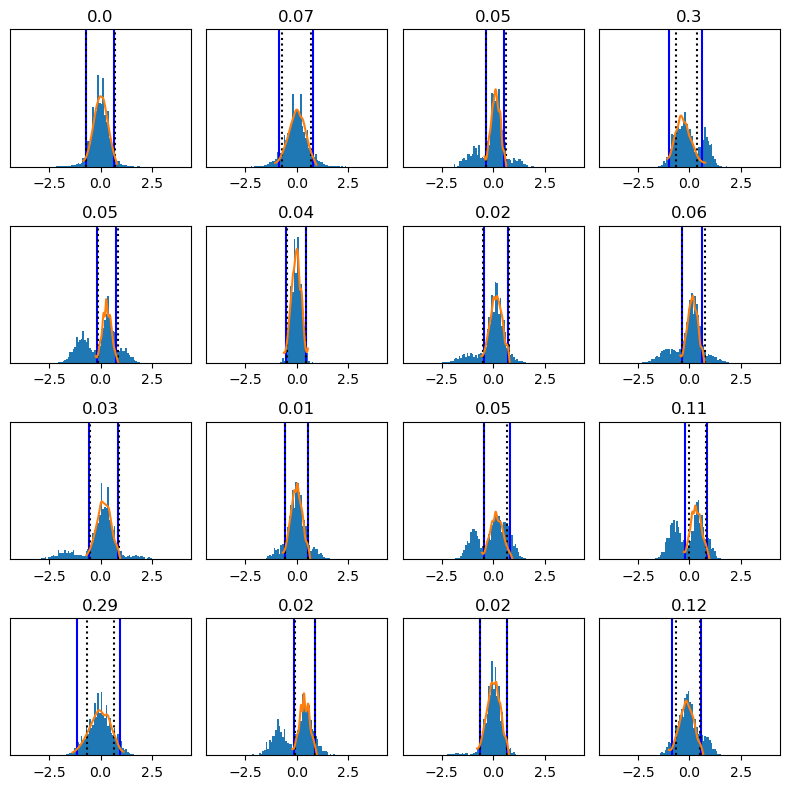

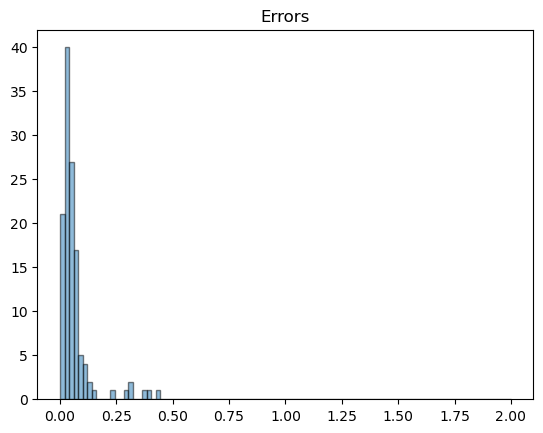

In [21]:
nr = 4
nc = 4
# idx = np.random.choice(len(test_x), nr*nc)
check_analyte = 'Hb'
idx = np.where(test_analytes==check_analyte)[0]
idx = np.random.choice(idx, nr*nc)
# idx = np.random.choice(idx[np.where(errors[idx]>0.20)[0]], nr*nc)
plt.figure(figsize=(8, 8))
for c,i in enumerate(idx):
    plt.subplot(nr, nc, c+1)
    plt.hist(data_scaled[i], np.linspace(-4, 4, 101), density=True);
    for j in test_p_ris[i]:
        plt.axvline(j, c='b')
    for j in test_y_scaled[i]:
        plt.axvline(j, c='k', linestyle=':')
    plt.yticks([])
    plt.ylim([0, 2])
    plt.title(round(errors[i], 2))
    plot_pdf_from_quantiles(test_p[i][:-1], test_p[i][-1])
plt.tight_layout()
plt.figure()
plt.hist(errors[np.where(test_analytes==check_analyte)[0]], np.linspace(0, 2, 100), edgecolor='k', alpha=0.5);
plt.title('Errors');
